# Catan Board Generation

## Todo
- [x] Move to notebooks
- [x] Create git repo
- [x] Install git notebook extensions https://coderefinery.github.io/jupyter/version-control/
- [x] Play around with SVG library to see if it would be better https://pypi.org/project/drawSvg/
- [x] Convert point class to a collections.namedtuple https://docs.python.org/3.8/library/collections.html#collections.namedtuple
- [x] Tidy code
- [x] Refactor code so that it uses a hexagonal co-ordinate system https://www.redblobgames.com/grids/hexagons/#hex-to-pixel
- [x] Make display_board modular
- [x] Add dots to tokens
- [x] Fix issues when changing hex sizes
- [x] Use ordered elements append to create layers 
- [x] Figure out vertices
- [x] Add empty outer layer
- [x] Draw ports (4 x 3:1 + 5 x 2:1)
- [x] Add ports to board logic
- [x] Tidy up new code
- [x] Comment new functions
- [ ] Migrate to new notebook, tidy in the process.
- [ ] Think about metric for measuring types of neighbours
- [ ] Add in token metrics to wrapping it up
- [ ] Figure out how to make colour blind friendly
- [ ] Think about metrics
- [ ] Calculate number of possible boards

## Imports

In [1]:
from math import sqrt, sin, cos, pi, isclose
from __future__ import annotations
import os
from random import randint, shuffle, seed
from dataclasses import dataclass, field
import drawSvg as draw
from statistics import variance as var
from statistics import mean
import numpy as np


seed(2022)

## Board code

### Data Structures

In [62]:
@dataclass
class Point:
    """Implements two dimensional points.
    
    Attributes:
        x: A float denoting the point's coordinate along the x axis.
        y: A float denoting the point's coordinate along the y axis.
    """
    
    x: float
    y: float
    
@dataclass
class Hex:
    """Implements a discrete hexagonal co-ordinate system.
    
    Three axes, q, r and s are used. Each location in the system satisfies 
    the constraint q + r + s = 0, so we don't need to request all three as
    input, as the third can be calculated (e.g. s = -q - r). 
    
    See www.redblobgames.com/grids/hexagons/ for more details on hexagonal
    co-ordinate systems.
    
    Attributes:
        q: An int denoting the hexagon's coordinate along the q axis.
        r: An int denoting the hexagon's coordinate along the r axis.
        s: An int denoting the hexagon's coordinate along the s axis.
    """
    
    q: int
    r: int
    s: int = field(init=False)
    
    def __post_init__(self):
        self.s = -self.q - self.r

    def __eq__(self, other):
        return self.q == other.q and self.r == other.r
    
    def __add__(self, other):
        return Hex(self.q + other.q, self.r + other.r)
    
    def __hash__(self):
        return hash((self.q, self.r))
    

@dataclass
class Board:
    """Implements a board data structure.
    
    Board objects are used to store 
    
    Attributes:
        hexes: A set of hexes that make up the board.
        hex_types: A dict containing the types of each hex.
        hex_tokens: A dict containing the token on each hex.
        harbors: A set containing the locations of each harbor.
        harbor_types: A dict containing the type of each harbor.
        hex_harbors: A dict containing the harbors, using the hexes as keys.
    """
    
    hexes: set[Hex] = field(default_factory=set)
    hex_types: dict[Hex, str] = field(default_factory=dict)
    hex_tokens: dict[Hex, int] = field(default_factory=dict)
    harbors: set[tuple[tuple[Hex]]] = field(default_factory=set)
    harbor_types: dict[tuple[tuple[Hex]], str] = field(default_factory=dict)
    hex_harbors: dict[Hex, list[str]] = field(default_factory=dict)
    

@dataclass
class Vertex:
    """Implements a hexagon vertex.
    
    Attributes:
        q: INSERT HERE.
        r: INSERT HERE.
        d: Direction (top or bottom)
    """
    
    q: int
    r: int
    d: str
    
    def __hash__(self):
        return hash((self.q, self.r, self.d))

'''
@dataclass
class Vertex_Triple:
    """Implements a hexagon vertex.
    # TODO: Is this the best way to do this?
    
    Attributes:
        h1: INSERT HERE.
        h2: INSERT HERE.
        h3: INSERT HERE.
    """
    hex_triple: list[Hex]
    
    def __eq__(self, other):
        Counter(self.hex_triple) == Counter(other.hex_triple)
        
    def __hash__(self):
        return hash((self.hex_triple[0], self.hex_triple[1], self.hex_triple[2]))
'''
def get_vertices(h):
    q, r = h.q, h.r
    vertices = [
        Vertex(q, r, 't'), 
        Vertex(q, r + 1, 'b'),
        Vertex(q + 1, r - 1, 't'),
        Vertex(q, r, 'b'),
        Vertex(q, r - 1, 't'),
        Vertex(q - 1, r + 1, 'b')
    ]
    return vertices

# print(get_vertices(Hex(0,0)))

def vertex_to_hex_trip(v):
    q, r, d = v.q, v.r, v.d
    h1 = Hex(q,r)
    if d == 't':
        h2, h3 = Hex(q - 1, r + 1), Hex(q, r + 1)
    else:
        h2, h3 = Hex(q + 1, r - 1), Hex(q, r - 1)
    return [h1, h2, h3]

# print(vertex_to_hex_trip(Vertex(q=0, r=0, d='t')))

### Functions used to generate a symbolic representation of the board

In [3]:
def init_board(board: Board = Board(), radius: int = 2) -> Board:
    """Initialises a hexagonal board.
    
    Creates a hexagonal board with a given radius. A radius of r means that the 
    minimum and maximum value for each axis is -r and r respectively.  
    
    Args:
        radius: A float, the desired radius of the board.
            
    Returns:
        A Board object, with hexes stored in the hexes attribute.    
    """
    
    board = Board()
    board.radius = radius
    # radius += 1  # Need a surrounding ring of 'null' hexes for vertex id
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            board.hexes.add(Hex(q,r))

    return board


def assign_hex_types(board: Board, hex_types: list[str]) -> None:
    """Assigns types to the board hexes.
    
    Each hex on the board is assigned one of a select number of types,
    representing the type of resource produced by that hex.
    
    Args:
        board: A Board object containing the hexes to assign types to.
        hex_types: A list of strings, containing the types available to assign,
            with each type repeated as many times as it can be assigned to 
            distinct hexes. For example, if we wanted to assign the 'grain'
            type to three different hexes on our board, the string 'grain'
            would appear three times in hex_types.  
    """
    
    hex_types = hex_types.copy()
    shuffle(hex_types)
    for hex_ in board.hexes:
        board.hex_types[hex_] = hex_types.pop()


def assign_hex_tokens(board: Board, tokens: list[str]) -> None:
    """Assigns tokens to the board hexes.
    
    Each hex on the board is assigned one token, with value between 2 and 12.
    The hex generates resources of its type when its token value is rolled.
    
    Args:
        board: A Board object containing the hexes to assign tokens to.
        hex_tokens: A list of ints, containing the token values available to
        assign, with each value repeated as many times as it can be assigned
        to distinct hexes. 
    """
        
    tokens = tokens.copy()
    shuffle(tokens)
    for hex_ in board.hexes:
        if board.hex_types[hex_] != 'desert':
            token = tokens.pop()
        else:
            token = None
        board.hex_tokens[hex_] = token

        
def assign_harbors(board: Board, 
                harbor_locations: list[list[tuple[Hex]]],
                harbor_types: list[str]) -> None:
    """Assigns harbors around the board.
    
    Harbors can be placed around the edge of the board, allowing players to
    more efficiently trade in resources.
    
    Args:
        board: A Board object containing the hexes to assign types to.
        harbor_locations: A list of vertex pairs (where each vertex is a 
            triple of hexes), denoting the locations to place the harbors.
        harbor_types: A list of strings, containing the harbor types available
            to assign, with each type repeated as many times as it can be 
            assigned to distinct hexes.
    """
    
    harbor_types = harbor_types.copy()
    shuffle(harbor_types)
    for vertex_pair in harbor_locations:
        board.harbors.add(vertex_pair)
        harbor_type = harbor_types.pop()
        board.harbor_types[vertex_pair] = harbor_type
        for vertex in vertex_pair:
            for hex_ in vertex:
                if hex_ in board.hexes:
                    try:
                        board.hex_harbors[hex_].add(harbor_type)
                    except KeyError:
                        board.hex_harbors[hex_] = set([harbor_type])
                                    
        
def create_random_board(radius: int, 
                        hex_types: list[str], 
                        tokens: list[int],
                        harbor_locations: list[list[tuple[Hex]]],
                        harbor_types: list[str]) -> Board:
    """Creates a randomly initialised board.
    
    Convenient wrapper for calling the functions required to generate a
    complete board.
    
    Args:
        radius: An int, as described in init_board().
        hex_types: A list of strings, as described in assign_hex_types().
        tokens: A list of ints, as described in assign_hex_tokens().
        harbor_locations:  A list of vertex pairs, as described in
            assign_harbors().
        harbor_types: A list of strings, as described in assign_harbors().
        
    Returns:
        board: A dict, as described in init_board().
    """
    
    board = init_board(radius = radius)
    assign_hex_types(board, hex_types)
    assign_hex_tokens(board, tokens)
    assign_harbors(board, harbor_locations, harbor_types)
    return board

### Functions used to create a visual representation of the board

In [4]:
def rotate(point: Point, angle: float, origin: Point=Point(0, 0)) -> Point:
    """Rotates a two dimensional point by a given angle about another point.
    
    Args:
        point: A Point, the point to rotate.
        angle: A float, the angle, in radians, to rotate point by.
        origin: A Point, the point by which to center the rotation around.
        
    Return:
        p_r: A Point, the image of point under the specified rotation.
    """
    
    p = point
    o = origin
    a = angle
    del_x = p.x - o.x
    del_y = p.y - o.y
    x = o.x + del_x * cos(a) - del_y * sin(a)
    y = o.y + del_x * sin(a) + del_y * cos(a)
    p_r = Point(x, y)
    return p_r


def hex_to_center_pixel(hex_: Hex, size: float) -> Point:
    """Converts hex coords to a single xy coord denoting the hex's center.
    
    To render the hexes on a screen, conversion between hex co-ordinates and two 
    dimensional cartesian coordinates is required. This function converts the
    coords of the given hex to a single 2D point, which denotes the location
    of the center of the hex in the cartesian coordinate system. 
    
    Args:
        hex_: A Hex, the hex to calculate the center coord of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        center: A Point, the center of the hex to be rendered.
    """
    
    x = size * (sqrt(3) * hex_.q + sqrt(3)/2 * hex_.r)
    y = size * (3/2 * hex_.r)
    center = Point(x,y)
    return center


def hex_to_vertex_pixels(hex_: Hex, size: float) -> list[Point]:
    """Converts hex coords to six xy coords denoting the hex's vertices.
    
    Similar to hex_to_center_pixel(), but calculates coords of the vertices
    instead of the coords of the center.
    
    Args:
        hex_: A Hex, the hex to calculate the vertex coords of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        points: A list of six Points, denoting the coords of the hex vertices.  
    """
    
    center = hex_to_center_pixel(hex_, size)
    p1 = Point(center.x, center.y + size)
    angles = [pi/3 * x for x in range(6)]
    points = [rotate(p1, angle, center) for angle in angles]
    return points

def hex_intersection_to_vertex_pixel(h1: Hex, h2: Hex, h3: Hex) -> Point:
    """Converts 3 hex coords to a single xy coord denoting their shared vertex.
    
    Vertices in a hex coord system are shared between three hexes. This
    calculates the cartesian coordinate of the vertex that is uniquely
    identified by these three vertices. 
    
    Args:
        h1: A Hex that contains the vertex.
        h2: A Hex that contains the vertex.
        h3: A Hex that contains the vertex.
        
    Return:
        vertex: A Point with coordinates of the shared vertex.  
    """
    
    c1 = hex_to_center_pixel(h1, 50)
    c2 = hex_to_center_pixel(h2, 50)
    c3 = hex_to_center_pixel(h3, 50)
    vertex = Point((c1.x + c2.x + c3.x)/3, (c1.y + c2.y + c3.y)/3)
    return vertex

def points_to_coordinate_list(points: list) -> list[float]: 
    """Concatenates co-ordinates of a list of points into a list of floats.
    
    For example, the list [Point(x=1, y=2), Point(x=3, y=4)] would be flattened
    to a list of floats, [1, 2, 3, 4]. 
    
    This format is required for compatibility with the drawSvg functions.
    
    Args:
        vertices: A list of Points.
        
    Return:
        points: A list of floats, flattended coords of the points.
    """
    
    coordinates = []
    for point in points:
        coordinates.append(point.x)
        coordinates.append(point.y)
    return coordinates

In [5]:
def roll_freq(value: int):
    """ Returns the relative frequency of a value being rolled by two dice.
    
    Returns the number of ways a value, between 2 and 12 inclusive, can be
    rolled by two, standard six sided die.
    
    Args:
        value: An int between 2 and 12.
    
    Return:
        rel_freq: An int, the number of different ways to roll value.
    """
    assert value >= 2 and value <= 12
    rel_freq = 6 - abs(7 - value)
    return rel_freq


def init_canvas(width, height):
    """ Initialise the SVG canvas on which to draw the board.
    """
    d = draw.Drawing(width, height, origin='center')
    return d


def draw_background(d):
    """ Draw the background/water hex.
    """
    vertex_coords = hex_to_vertex_pixels(Hex(0,0), hex_size * 5.8)
    for i in range(len(vertex_coords)):
        vertex_coords[i] = rotate(vertex_coords[i], pi/6)
    vertex_coords = points_to_coordinate_list(vertex_coords)
    d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours['water'],
                            stroke=stroke_colour, stroke_width=stroke_width),
            z=0)
    
    
def draw_board_outline(d, board):
    """ Draw a plain outline of the board.
    """
    for hex_ in board.hexes:
        vertex_coords = points_to_coordinate_list(
            hex_to_vertex_pixels(hex_, hex_size))
        coords = (hex_.q, hex_.r)
        d.append(draw.Lines(*vertex_coords,
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            coords = coords
                           ),
                z=1)

        
def fill_board(d, board):
    """ Fill the board hexes with their type colours.
    """
    for element in d.allElements():
        try:
            coords = element.args['coords']
            fill_colour = hex_colours[board.hex_types[Hex(*coords)]]
            element.args['fill'] = fill_colour
        except KeyError: pass

        
        
def draw_tokens(d, board, show_dots=True):
    """ Draw each hexes token on the board.
    """
    
    radius = 25
    
    for hex_ in board.hexes:
        center = hex_to_center_pixel(hex_, hex_size)
        hex_token = board.hex_tokens[hex_]
        if hex_token is not None:
            if hex_token == 6 or hex_token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            font_size = 31 - 2.5 * abs(7 - hex_token)

            d.append(draw.Circle(center.x, center.y, 
                                 r=radius, fill=token_fill_colour), 
                     z=2)

            if show_dots: 
                vert_off = 3 
            else: 
                vert_off = 0

            d.append(draw.Text(str(hex_token), fontSize=font_size, 
                               x=center.x, y=center.y + vert_off, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_colour, font_weight = 'bold'),
                     z=3)

            if show_dots:
                r = 1.6
                num_dots = roll_freq(hex_token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_del = 3*r/2 + (i - 1) * 3 * r
                        dots.append(Point(center.x + x_del, center.y - 15))
                        dots.append(Point(center.x - x_del, center.y - 15))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_del = 3 * r * i
                        dots.append(Point(center.x + x_del, center.y - 15))
                        if x_del != 0:
                            dots.append(Point(center.x - x_del, center.y - 15))

                for dot in dots:
                    d.append(draw.Circle(dot.x, dot.y, r, 
                                         fill = token_colour), z=3)
        

def draw_coords(d, board):
    """Display the coords of each hex on the board. 
    """
    for hex_ in board.hexes:
        coords = (hex_.q, hex_.r, hex_.s)
        center = hex_to_center_pixel(hex_, hex_size)
        d.append(draw.Text(str(coords), fontSize=18, 
                   x=center.x, y=center.y, center=True, 
                   valign = 'middle', font_family = "Open Sans", 
                   fill = 'black'), 
                 z=2)

def draw_harbors(d, board, simple=False):
    """Draw the harbors onto the board.
    """
    for vertex_pair in board.harbors:
        p1 = hex_intersection_to_vertex_pixel(*vertex_pair[0])
        p2 = hex_intersection_to_vertex_pixel(*vertex_pair[1])
        p3 = rotate(p1, pi/3, p2)
        harbor_type = board.harbor_types[vertex_pair]
        fill = harbor_colours[harbor_type]
        ratio = 3 if harbor_type == 'generic' else 2
        if not simple:
            harbor_fill = token_fill_colour
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               fontSize=12, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3.x, y=p3.y, center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbor_fill = fill
        
        d.append(draw.Circle(p3.x, p3.y, r=13, 
                     fill=harbor_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=4), z=3)
        d.append(draw.Line(p1.x, p1.y, p3.x, p3.y, 
                           stroke = 'black', stroke_width=3,
                           stroke_opacity = 0.5), z=1)
        d.append(draw.Line(p2.x, p2.y, p3.x, p3.y, 
                           stroke ='black', stroke_width=3, 
                           stroke_opacity = 0.5), z=1)

        
def draw_complete_board(board, width, height, simple=False):
    """Draw the board, wrapper function.
    """
    show_dots = False if simple else True
    d = init_canvas(width, height)
    draw_background(d)
    draw_board_outline(d, board)
    fill_board(d, board)
    draw_tokens(d, board, show_dots=show_dots)
    draw_harbors(d, board, simple=simple)
    return d
    

### Creating the board

In [6]:
hex_types = (4 * ['wool'] + 
         4 * ['grain'] + 
         4 * ['lumber'] + 
         3 * ['ore'] + 
         3 * ['brick'] + 
         1 * ['desert'])

tokens = (1 * [2] + 
          2 * [3] + 
          2 * [4] + 
          2 * [5] + 
          2 * [6] + 
          2 * [8] + 
          2 * [9] + 
          2 * [10] + 
          2 * [11] + 
          1 * [12])

harbor_locations = [  # Vertices are defined by hex triples
    ((Hex(0,2), Hex(-1, 2), Hex(-1,3)), (Hex(-1,2), Hex(-1,3), Hex(-2,3))),
    ((Hex(-2,2), Hex(-2,3), Hex(-3,3)), (Hex(-2,2), Hex(-3,3), Hex(-3,2))),
    ((Hex(-2,1), Hex(-3,2), Hex(-3,1)), (Hex(-2,1), Hex(-2,0), Hex(-3,1))),
    ((Hex(-2,0), Hex(-1,-1), Hex(-2,-1)), 
     (Hex(-1,-2), Hex(-1,-1), Hex(-2,-1))),
    ((Hex(0,-2), Hex(-1,-2), Hex(0,-3)), (Hex(0,-2), Hex(0,-3), Hex(1,-3))),
    ((Hex(1,-2), Hex(1,-3), Hex(2,-3)), (Hex(1,-2), Hex(2,-3), Hex(2,-2))),
    ((Hex(2,-1), Hex(2,-2), Hex(3,-2)), (Hex(2,-1), Hex(3,-2), Hex(3,-1))),
    ((Hex(2,0), Hex(3,0), Hex(3,-1)), (Hex(2,0), Hex(3,0), Hex(2,1))),
    ((Hex(1,1), Hex(1,2), Hex(2,1)), (Hex(1,1), Hex(1,2), Hex(0,2)))
]

harbor_types = (1 * ['wool'] + 
                1 * ['grain'] + 
                1 * ['lumber'] + 
                1 * ['ore'] +
                1 * ['brick'] + 
                4 * ['generic'])

In [7]:
board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)

In [8]:
sys.getsizeof(board)

NameError: name 'sys' is not defined

### Visualising the board

In [15]:
width = 600
height = width
hex_size = 50
hex_colours = {
    'wool': '#a7c957',
    'grain': '#DFB853',
    'lumber': '#20703D',
    'ore': '#969696',
    'brick': '#C37C3A',
    'desert': '#DCBB96',
    'water': '#B9E3F3'
}
token_fill_colour = "#FFEDD0"
token_text_colour = ("#BD0000", "#100C08")
harbor_colours = { # Darker shades of hex_colours
    'wool': '#93B93C',
    'grain': '#D9A82E',
    'lumber': '#1B5F34',
    'ore': '#969696',
    'brick': '#A86B32',
    'generic': '#2A1B0D'
}
font_family = "Open Sans"
stroke_colour = "#100C08"
stroke_width = 3

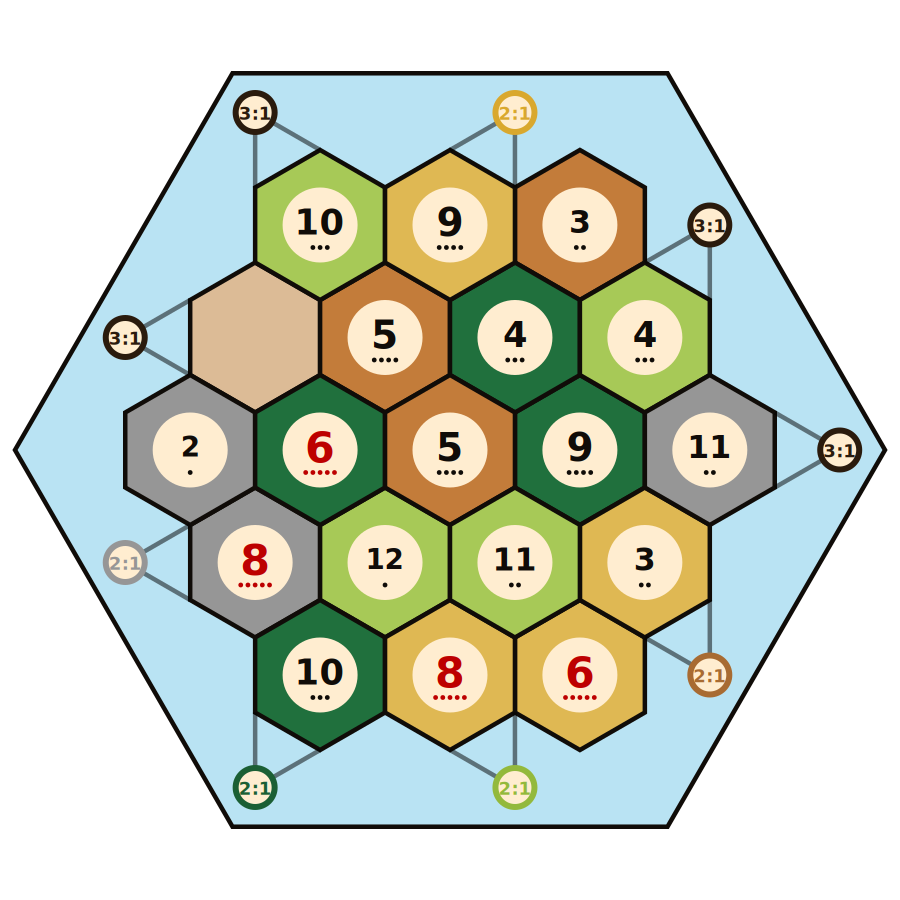

In [16]:
d = draw_complete_board(board, width, height)
d.setPixelScale(1.5)
# draw_coords(d, board)
# d.saveSvg('board.svg')
# d.savePng('board.png')
d

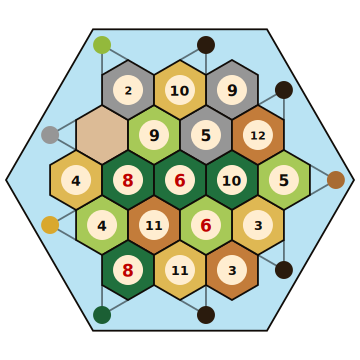

In [17]:
board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)
d = draw_complete_board(board, width, height, simple=True)
d.setPixelScale(0.6)
d

# Metrics

## Tokens
- [x] Token distribution across hex types
- [ ] Token distribution across board locations 

## Types
- [ ] Terrain distribution across the board
    - [x] Global distribution: symmetry
    - [ ] Local distribution: terrain clusters


## Ports
- Port proximity to respective resource
- Port "diversity" (mixing of 2:1 and 3:1)

In [18]:
def normalise(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

# Tokens

## Token distribution across hex types
- How are the token numbers spread between the different hex types?
- We could consider the distributions to be more 'fair' if each hex type has a roughly equal chance of producing resources each turn.

In [19]:
def calc_token_hex_score(board):
    dist = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}    

    for hex_ in board.hexes:
        hex_type = board.hex_types[hex_]
        if hex_type != 'desert':
            dist[hex_type] += roll_freq(board.hex_tokens[hex_])

    for key in dist.keys():
        if key in ['wood', 'grain', 'lumber']:
            dist[key] = dist[key] / 4
        else:
            dist[key] = dist[key] / 3

    v = var(dist.values()) * 5 # TODO: Make this more elegant

    return v
    

## Token distribution across location
- How are the token numbers spread across the board by location?
- Break down into two categories:
    - Probability: We could consider the distribution to be 'fair' if each vertex roughly equal chance (accounting for the number of adjacent tiles) of producing resources per turn.
    - Diversity: We could consider the distribution to be 'balanced' if adjacent hexes don't share the same token number. 

### Probability

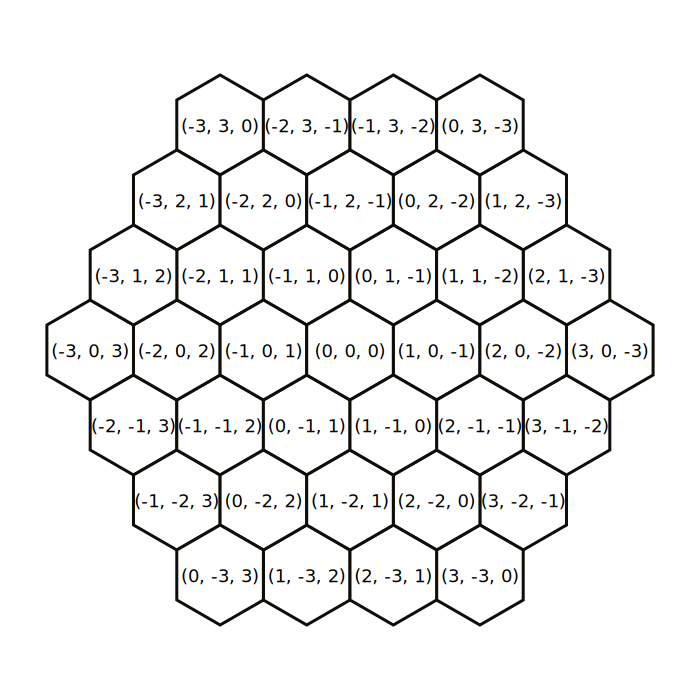

In [20]:
d = init_canvas(700, 700)
b = init_board(radius = 3)
draw_board_outline(d, b)
draw_coords(d, b)
d

In [57]:
def calc_vertex_prob_score(board):
    # TODO: Make this into a separate function
    vertex_set = set()
    for hex_ in board.hexes:
        vertices = get_vertices(hex_)
        vertex_set.update(vertices)
    
    prob_list = []
    for v in vertex_set:
        hexes = vertex_to_hex_trip(v)
        prob = 0
        num_tiles_on_board = 0
        # print(f"hex triple = {hexes}")
        for hex_ in hexes:
            if hex_ in board.hexes:
                num_tiles_on_board += 1
                hex_token = board.hex_tokens[hex_]
                if hex_token is not None:
                    prob += roll_freq(hex_token)
                    # print(f"hex = {hex_}")
                    # print(f"token = {hex_token}, dots = {roll_freq(hex_token)}")

        weighted_prob = prob * num_tiles_on_board/3
        # print(f"Total prob = {prob}, w_prob = {weighted_prob}")
        prob_list.append(weighted_prob)
    
    prob_var = var(prob_list)
    return(prob_var)

    # prob_delta = max(prob_list) - min(prob_list)
    # return prob_delta

In [22]:
1e8/20369419560 * 100

0.49093200572279827

In [23]:
n_iter = int(1e5)
boards = []

for i in range(n_iter):
    boards.append(create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types))

In [24]:
# import sys
# sys.getsizeof(boards) / 1e6

In [58]:
v_prob_scores = []

for i in range(n_iter):
    board = boards[i]
    v_prob_scores.append(calc_vertex_prob_score(board))

In [59]:
v_prob_scores_n = normalise(v_prob_scores)

np.sort(v_prob_scores_n)[:10]
np.argsort(v_prob_scores_n)[:10]
top_board = np.argsort(v_prob_scores_n)[0]

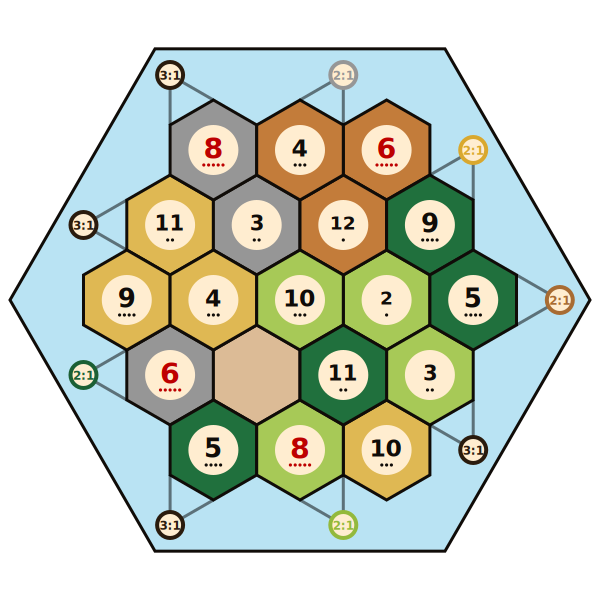

In [60]:
d = draw_complete_board(boards[np.argsort(v_prob_scores_n)[2]], width, height)
d

Problem: This results in 'weird' distributions of tokens. Maybe better off trying to make each hex neighbour hexes with different number of dots?

In [28]:
from collections import Counter

a = [Hex(0,0), Hex(1,0), Hex(0,1)]
b = [Hex(1,0), Hex(0,0), Hex(0,1), Hex(2,2)]

Counter(a) == Counter(b)

False

### Diversity

# Terrains

## Global distribution
- How are the terrains spread over the board overall?
- Multiple candidate approaches, including:
    - Maximising the sum of average distances between tiles with the same terrain.
    - Minimising the difference in the number of terrain types on opposite sides of axes.


In [29]:
def get_terrain_locations(board: board, terrain: str):
    locations = []
    for hex_ in board.hexes:
        hex_type = board.hex_types[hex_]
        if hex_type == terrain:
            locations.append(hex_)
    return locations
            

def hex_distance(h1, h2):
    distance = max(abs(h1.q - h2.q), abs(h1.r - h2.r), abs(h1.s - h2.s))
    return distance

The minimising variance of the average distance doesn't produce nice results. 

In [30]:
locations = get_terrain_locations(board, 'lumber')
print(locations)
distances = [] 

# TODO: Make this more efficient, double counts each edge
for h1 in locations:
    for h2 in locations:
        if h1 != h2:
            distance = hex_distance(h1, h2)
            distances.append(distance)
            
print(mean(distances))


[Hex(q=-1, r=-1, s=2), Hex(q=-2, r=1, s=1), Hex(q=2, r=-1, s=-1), Hex(q=1, r=-1, s=0)]
2.5


In [31]:
min_var = 100
min_dist = None 
min_board = None


hex_types_unique = list(set(hex_types))
hex_types_unique.remove('desert')

for i in range(10000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)
    avg_distances = []

    for hex_type in hex_types_unique:
        locations = get_terrain_locations(board, hex_type)
        distances = [] 

        # TODO: Make this more efficient, double counts each edge
        for h1 in locations:
            for h2 in locations:
                if h1 != h2:
                    distance = hex_distance(h1, h2)
                    distances.append(distance)
        avg_distances.append(mean(distances))
            

    v = var(avg_distances)
    if v < min_var:
        min_var = v
        min_dist = avg_distances
        min_board = board


0
[2, 2, 2, 2, 2]


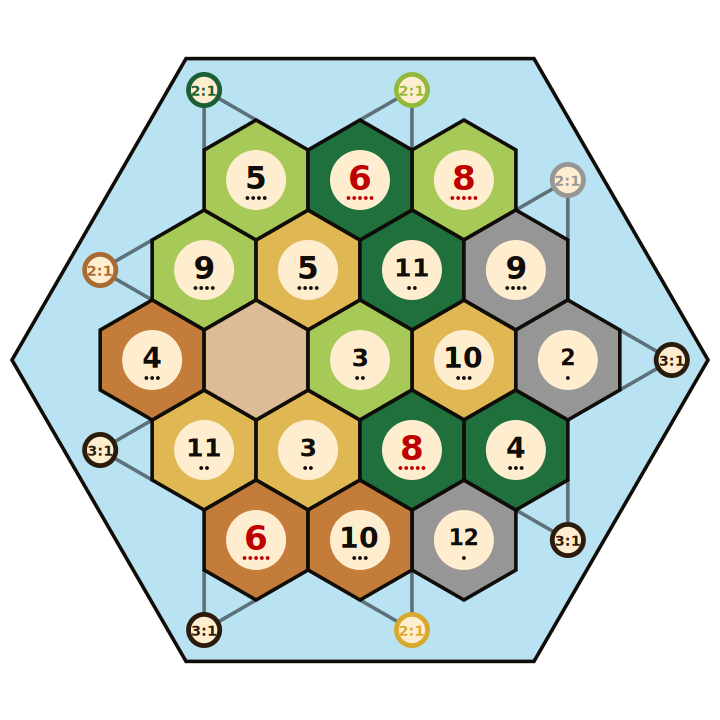

In [32]:
print(min_var)
print(min_dist)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

### Maximising sum of average distances

In [33]:
max_sum = 0
max_dist = None 
min_board = None


hex_types_unique = list(set(hex_types))
hex_types_unique.remove('desert')

for i in range(100000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)
    avg_distances = []

    for hex_type in hex_types_unique:
        locations = get_terrain_locations(board, hex_type)
        distances = [] 

        # TODO: Make this more efficient, double counts each edge
        for h1 in locations:
            for h2 in locations:
                if h1 != h2:
                    distance = hex_distance(h1, h2)
                    distances.append(distance)
        avg_distances.append(mean(distances))
            

    s = sum(avg_distances)
    if s > max_sum:
        max_sum = s
        max_dist = avg_distances
        min_board = board


14.666666666666668
[2, 2, 2, 2, 2]


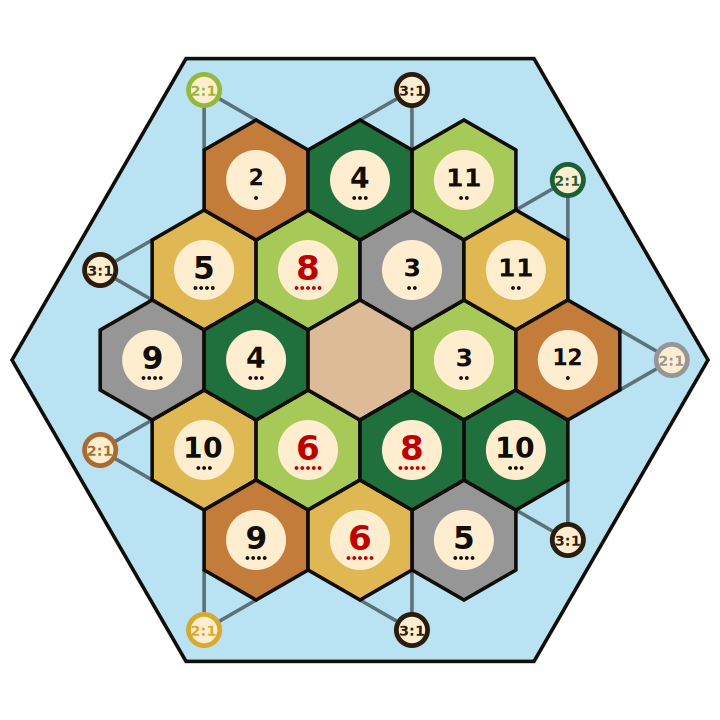

In [34]:
print(max_sum)
print(min_dist)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

### Minimising the difference in the number of terrain types on opposite sides of axes

In [35]:
min_sum = 100
min_board = None

for i in range(100000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)

    squared_diffs = 0
    for axis in ['q', 'r', 's']:
        count = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}
        for hex_ in board.hexes:
            hex_type = board.hex_types[hex_]
            if hex_type != 'desert':
                if getattr(hex_, axis) < 0:
                    count[hex_type] -= 1
                elif getattr(hex_, axis) > 0:
                    count[hex_type] += 1
        squared_diffs += sum([i**2 for i in count.values()])
    
    if squared_diffs < min_sum:
        min_sum = squared_diffs
        min_board = board
        

2


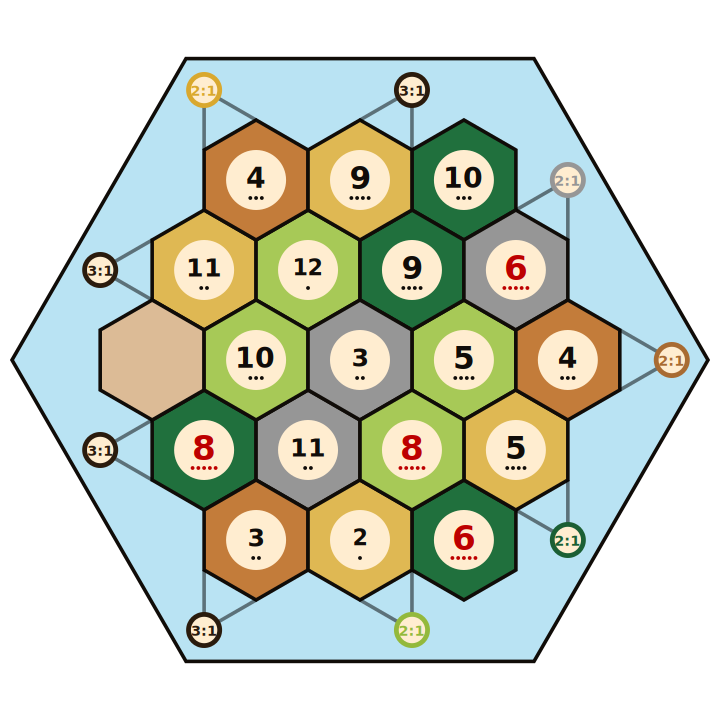

In [36]:
print(min_sum)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

## Local distribution
- The methods used above don't directly discourage an even distribution on a 'local' level; often optimising these measures along results in tiles of the same type clustering together.
- Ideally, no two resources of the same type should be adjacent.
- We create another metric to measure the number of neighbours a tile has of the same type, and attempt to minimise it.


Need an approach to directly penalise having neighbours of the same type.

In [37]:
def get_neighbours(hex_, board):
    directions = [Hex(1, 0), Hex(1, -1), Hex(0, -1), 
                  Hex(-1, 0), Hex(-1, 1), Hex(0, 1)]
    neighbours = []
    for vec in directions:
        neighbour = hex_ + vec
        if hex_distance(Hex(0,0), neighbour) <= board.radius:
            neighbours.append(neighbour)
            
    return neighbours


score = 0
for hex_ in board.hexes:
    neighbours = get_neighbours(hex_, board)
    hex_type = board.hex_types[hex_]
    for neighbour in neighbours:
        if board.hex_types[neighbour] == hex_type:
            score += 1

In [38]:
def calc_clustering_score(board):
    score = 0
    for hex_ in board.hexes:
        neighbours = get_neighbours(hex_, board)
        hex_type = board.hex_types[hex_]
        for neighbour in neighbours:
            if board.hex_types[neighbour] == hex_type:
                score += 1
    return(score)

def calc_symmetry_score(board):
    squared_diffs = 0
    for axis in ['q', 'r', 's']:
        count = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}
        for hex_ in board.hexes:
            hex_type = board.hex_types[hex_]
            if hex_type != 'desert':
                if getattr(hex_, axis) < 0:
                    count[hex_type] -= 1
                elif getattr(hex_, axis) > 0:
                    count[hex_type] += 1
        squared_diffs += sum([i**2 for i in count.values()])

    return squared_diffs


In [39]:
results = []
boards = []

n_iter = int(1e5)

for i in range(n_iter):
    board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)
    cluster_score = calc_clustering_score(board)
    results.append(cluster_score)
    boards.append(board)
    

In [40]:
results_sorted = np.sort(results)
indices_sorted = np.argsort(results)

In [41]:
for i in range(len(results_sorted)):
    if results_sorted[i] == 0:
        pass
    else:
        print(i)
        break
    

46


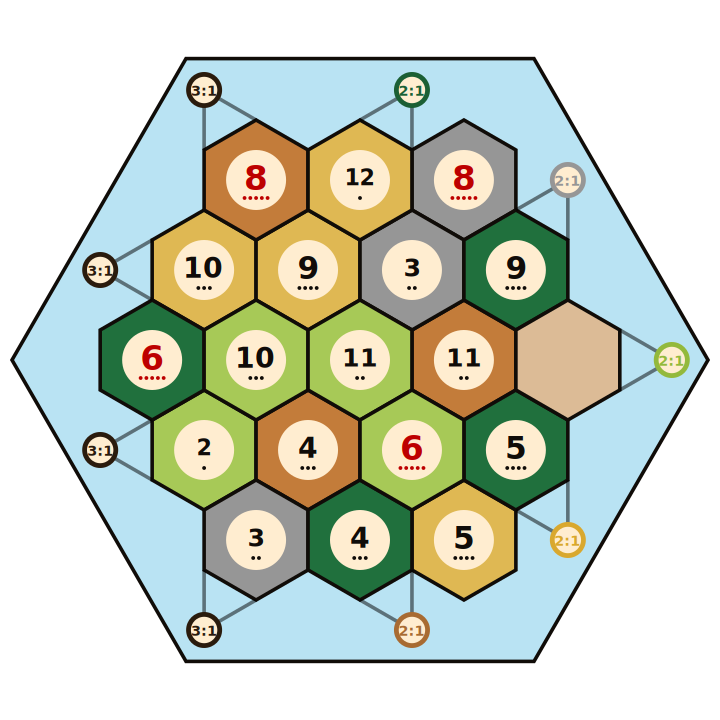

In [42]:
d = draw_complete_board(boards[28377], width, height)
d.setPixelScale(1.2)
d

## Packaging it together

In [43]:
cluster = []
symm = []
token_hex = []
v_freq = []
boards = []

n_iter = int(1e5)

for i in range(n_iter):
    board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)
    cluster.append(calc_clustering_score(board))
    symm.append(calc_symmetry_score(board))
    token_hex.append(calc_token_hex_score(board))
    v_freq.append(calc_vertex_prob_score(board))
    boards.append(board)

In [44]:
np.sort(normalise(token_hex))

array([0.        , 0.        , 0.        , ..., 0.97994896, 0.98487058,
       1.        ])

In [45]:
np.percentile(normalise(token_hex), [0.1, 25, 50, 75, 99.9])

array([0.0051039 , 0.10207802, 0.18009479, 0.29183376, 0.83211867])

In [46]:


token_hex_n = normalise(token_hex)
cluster_n = normalise(cluster)
symm_n = normalise(symm)
v_freq_n = normalise(v_freq)


w = 1
v = 1
u = 1
results_sum = cluster_n * w + symm_n +  v * token_hex_n + u * v_freq_n

In [47]:
n = 20
print(f"Top {n} result scores: \n {np.sort(results_sum)[:n]}")
print(f"Top {n} board indexes: \n {np.argsort(results_sum)[:n]}")

top_board_index = np.argsort(results_sum)[0]

Top 20 result scores: 
 [0.47145136 0.48142327 0.50310983 0.50420352 0.51954607 0.52767277
 0.52877148 0.53405729 0.53528059 0.53539151 0.53540462 0.53870846
 0.53996631 0.55554884 0.55794591 0.56036236 0.56339789 0.56366244
 0.56586349 0.57239888]
Top 20 board indexes: 
 [90523 44829 56708 71483 97601  1544 21402 67931 36629 67096 39442  2927
 21420 33582 82684 87656 34656 41939 22761 57777]


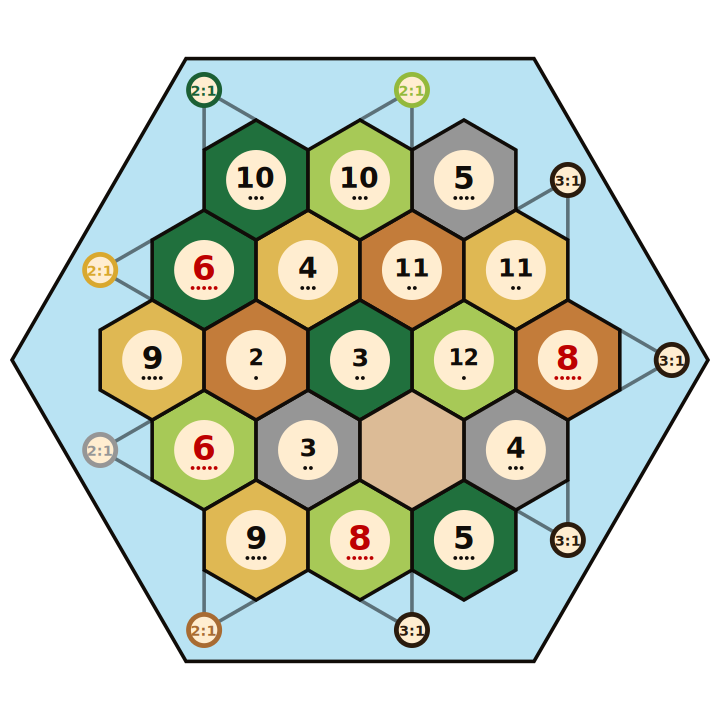

In [53]:
d = draw_complete_board(boards[top_board_index], width, height)
d.setPixelScale(1.2)
d

In [49]:
desert_origin = 0
for board in boards:
    if board.hex_types[Hex(0,0)] == "desert":
        desert_origin += 1
        
print(desert_origin/n_iter)

0.05257


In [50]:
desert_origin = 0
for i in range(100):
    board = boards[np.argsort(results_sum)[i]]
    if board.hex_types[Hex(0,0)] == "desert":
        desert_origin += 1
        
print(desert_origin/100)

0.06


# Compact boards
I'm running into memory problems, need a more compact way to represent boards.


In [51]:
def calc_number_hexes(radius):
    return 1 + 3 * radius * (radius + 1)

In [52]:
radius = 2
num_hexes = calc_number_hexes(radius)

i = 0
hex_map = np.zeros(shape = (num_hexes, 3), dtype = np.int8)

for q in range(-radius, radius + 1):
    r1 = max(-radius, -q - radius)
    r2 = min(radius, -q + radius)
    for r in range(r1, r2 + 1):
        hex_map[i] = np.array([q, r, -(q + r)])
        i += 1
# Using the hex_map we can refer to hexes by a single number, corresponding to 
# their index in this list. For example, 9 refers to the origin hex:
print(hex_map[9])

# Do the same thing for hex types, e.g. 0 represents the desert type
hex_type_map = np.array(['desert', 'grain', 'lumber', 'wool', 'brick', 'ore'])

[0 0 0]


In [ ]:
hex_types = (4 * ['wool'] + 
         4 * ['grain'] + 
         4 * ['lumber'] + 
         3 * ['ore'] + 
         3 * ['brick'] + 
         1 * ['desert'])

availible_hex_types = (4 * [1] + 
         4 * [2] + 
         4 * [3] + 
         3 * [4] + 
         3 * [5] + 
         1 * [0])

availible_tokens = (1 * [0] +
      1 * [2] + 
      2 * [3] + 
      2 * [4] + 
      2 * [5] + 
      2 * [6] + 
      2 * [8] + 
      2 * [9] + 
      2 * [10] + 
      2 * [11] + 
      1 * [12])

In [ ]:
def check_availible_features(num_hexes, hex_types, tokens):
    if len(hex_types) != num_hexes: print("ERROR: num_hexes != len(hex_types)")
    if len(tokens) != num_hexes: print("ERROR: num_hexes != len(tokens)")
    
def assign_hex_types(availible_hex_types: ndarray[int]) -> ndarray[int]:
    return np.random.permutation(availible_hex_types)

def assign_tokens(availible_tokens: ndarray[int], board_hex_types: ndarray[int]) -> ndarray[int]:
    "Need to ensure that the 'zero' token is on the desert hex."
    token_assignment = np.random.permutation(availible_tokens)
    desert_index = list(board_hex_types).index(0)
    token_zero_index = list(token_assignment).index(0)
    # Swap
    token_assignment[[desert_index, token_zero_index]] = token_assignment[[token_zero_index, desert_index]]
    
    return token_assignment





In [ ]:
n_iter = int(1e5)
boards = np.zeros(shape = (n_iter, 2, num_hexes), dtype = np.int8)

for i in range(n_iter):
    ht = assign_hex_types(availible_hex_types)
    tok = assign_tokens(availible_tokens, ht)
    boards[i] = np.array([ht, tok])

In [ ]:
sys.getsizeof(boards) / 1e6

In [ ]:
sys.getsizeof(boards[1])

In [ ]:
boards[1].nbytes